In [133]:
#%matplotlib notebook
%matplotlib inline
from matplotlib import rc
rc('figure',figsize=(16,8))
rc('font',size=12)
rc('text',usetex=False)

from qubicpack import qubicpack as qp
import fibtools as ft
import plotters as p
import lin_lib as ll
import demodulation_lib as dl

import numpy as np
from matplotlib.pyplot import *
import matplotlib.mlab as mlab
import scipy.ndimage.filters as f
import glob
import string
import scipy.signal as scsig
from scipy import interpolate

## Dataset

Get the directories corresponding to the day we consider:

In [134]:
day = '2019-02-22'
data_dir = '/qubic/Data/Calib-TD/'+day+'/'
dirs = np.sort(glob.glob(data_dir+'/*_Scan2'))
print dirs
labels = []
for d in dirs:
    bla = str.split(d,'__')
    labels.append(bla[1])
print labels
thedir = dirs[0]

['/qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2']
['Scan2']


## Reading Data for a given asic

In [135]:
AsicNum = 1
a = qp()
a.read_qubicstudio_dataset(thedir, asic=AsicNum)

Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Sums/science-asic1-2019.02.22.162801.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Sums/science-asic1-2019.02.22.162801.fits
Guessing the detector array is: P87
reading fits file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/hk-MMR-2019.02.22.162801.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/hk-MMR-2019.02.22.162801.fits
reading fits file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/hk-intern-2019.02.22.162801.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/hk-intern-2019.02.22.162801.fits
reading fits file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/conf-asics-2019.02.22.162801.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-02-22/2019-02-22_16.28.01__Scan2/Hks/

## Reading TES data

setting pps interval to 1 second


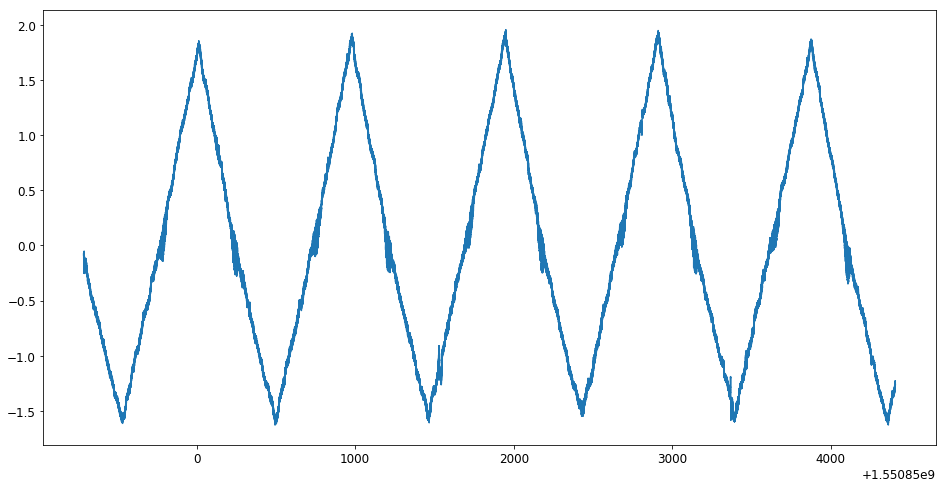

In [136]:
TESNum = 96
data = a.timeline(TES=TESNum)
t_data = a.timeline_timeaxis(axistype='pps')

plot(t_data, (data-np.mean(data))/np.std(data), label='Data')


## Reading Azimuth Data

setting pps interval to 1 second
(52939,)
(52939,)


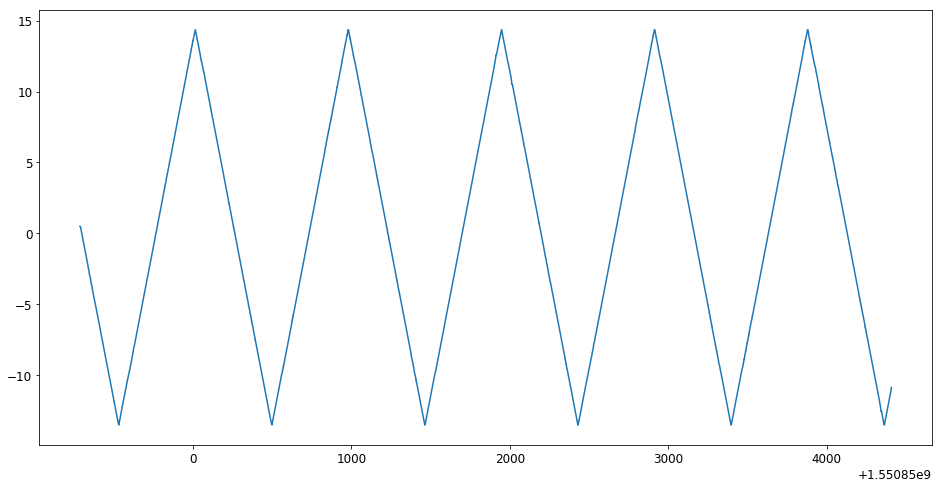

In [137]:
pps=a.pps(hk='INTERN_HK')
gps=a.gps(hk='INTERN_HK')
t_az = a.pps2date(pps,gps)
az = a.hk['INTERN_HK']['Platform-Azimut']
az = (az-2.**15)/(2.**16)*360

print t_az.shape
print az.shape
plot(t_az, az)

## Plot Data and Azimuth together (they should match)

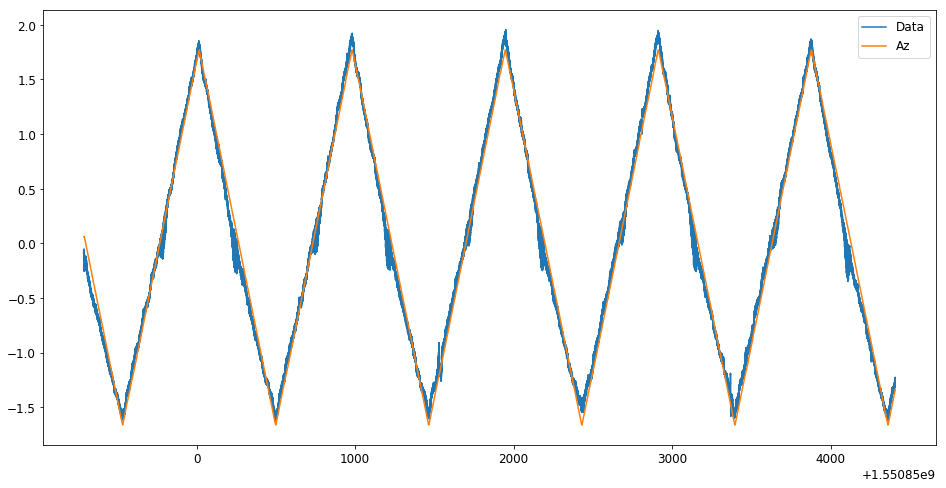

In [138]:
plot(t_data, (data-np.mean(data))/np.std(data), label='Data')
plot(t_az, (az-np.mean(az))/np.std(az), label='Az')
legend()

Let's check the modulation frequency (main peak in data)

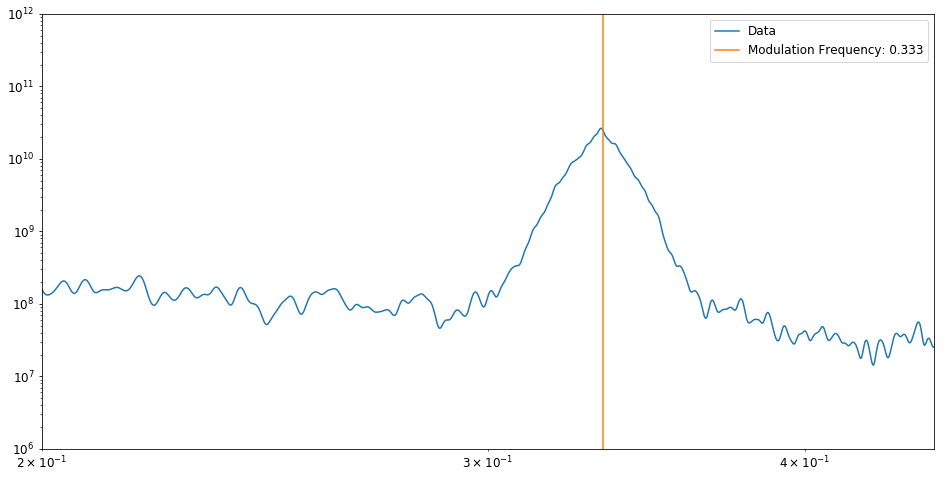

In [139]:
FREQ_SAMPLING = 1./(t_data[1]-t_data[0])
spectrum_f, freq_f = mlab.psd(data, Fs=FREQ_SAMPLING, NFFT=len(data), window=mlab.window_hanning)
plot(freq_f, f.gaussian_filter1d(spectrum_f,5),label='Data')
yscale('log')
xscale('log')
xlim(0.2,0.45)
freq_mod = 0.333
plot([freq_mod, freq_mod], [1e6, 1e12], label='Modulation Frequency: {}'.format(freq_mod))
ylim(1e6, 1e12)
legend()

## Reading Calibration Source Data

['/qubic/Data/Calib-TD/calsource/calsource_20190222T150113.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190222T161710.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190222T164144.dat']


(0, 200)

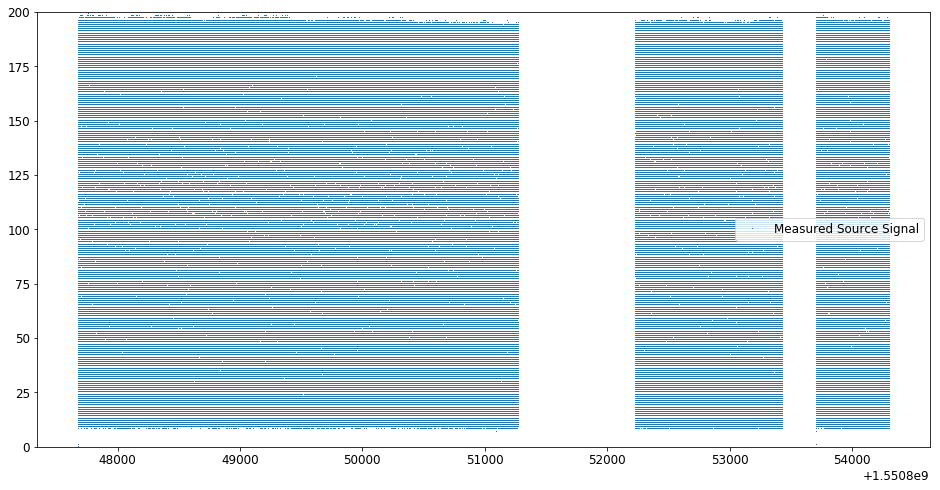

In [140]:
##### The date format for calsrc has no '-' so we need to change the day to this very format.
daycalsrc = "".join(str.split(day,'-'))
fcalsrc = glob.glob('/qubic/Data/Calib-TD/calsource/*'+daycalsrc+'*')
fcalsrc.sort()
print fcalsrc

reload(dl)
t_src, data_src = dl.read_cal_src_data(fcalsrc)
plot(t_src, data_src,',', label='Measured Source Signal')
legend()
ylim(0,200)

## Simulating CalSrc Data
Here we use the model of the calibration source data (written by Daniele Mennella using the documentation of the source that describes the instricic non linearity of the source). We use this instead of the Calibration Source Data itself that may not always be available. The tricky part here is probably the relative timing...

NB: the src_phase is to be adjusted manually (or will be fit later on)

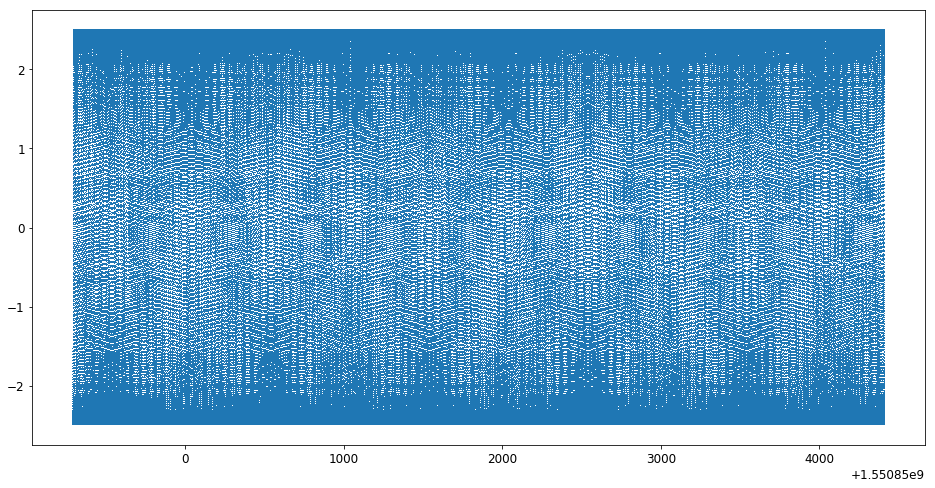

In [141]:
#### Source parameters
src_amp = 5.          # Volts
src_period = 1./0.333 # seconds
src_phase = 0.6        # Radians
src_offset = 2.5      # Volts

#### Source in the data parameters
src_amp_data = 5. 
src_off_data = -2.5

src_pars = np.array([src_amp_data, src_off_data, src_amp, src_period, src_phase, src_offset])
t_sim_src = t_data
data_sim_src = ll.sinesat(t_sim_src, src_pars,)

plot(t_sim_src, data_sim_src,',', label='Simulated Source Signal')

## Now Plot Data, Azimuth, Simulated and Measured source signal altogether
Data is filtered before plotting

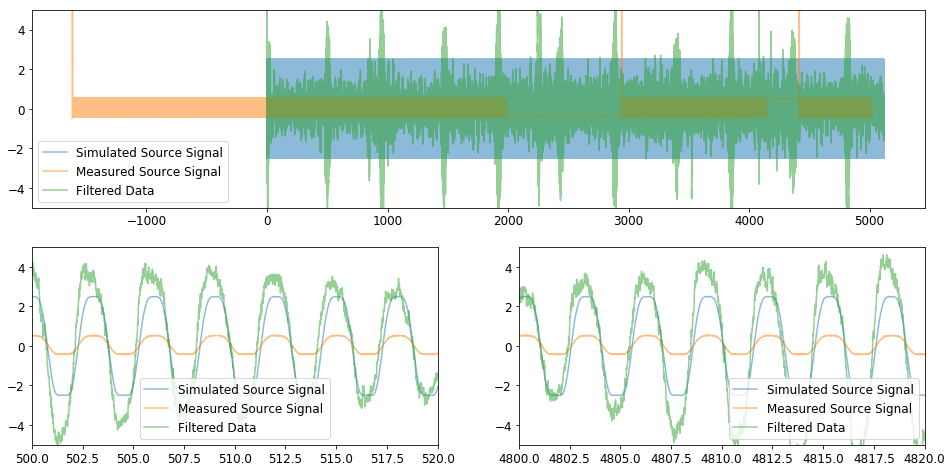

In [146]:
####
lowcut = 0.05
highcut = FREQ_SAMPLING/2
filt = scsig.butter(5, [lowcut / FREQ_SAMPLING, highcut / FREQ_SAMPLING], btype='bandpass', output='sos')
data_filtered = -scsig.sosfilt(filt, data)

subplot(2,1,1)
plot(t_sim_src-t_data[0], data_sim_src,label='Simulated Source Signal', alpha=0.5)
plot(t_src-t_data[0], (data_src-np.mean(data_src))/np.std(data_src), label='Measured Source Signal', alpha=0.5)
plot(t_data-t_data[0], (data_filtered-np.mean(data_filtered))/np.std(data_filtered), label='Filtered Data', alpha=0.5)
ylim(-5,5)
legend()
subplot(2,2,3)
plot(t_sim_src-t_data[0], data_sim_src,label='Simulated Source Signal', alpha=0.5)
plot(t_src-t_data[0], (data_src-np.mean(data_src))/np.std(data_src), label='Measured Source Signal', alpha=0.5)
plot(t_data-t_data[0], (data_filtered-np.mean(data_filtered))/np.std(data_filtered), label='Filtered Data', alpha=0.5)
ylim(-5,5)
xlim(500,520)
legend()
subplot(2,2,4)
plot(t_sim_src-t_data[0], data_sim_src,label='Simulated Source Signal', alpha=0.5)
plot(t_src-t_data[0], (data_src-np.mean(data_src))/np.std(data_src), label='Measured Source Signal', alpha=0.5)
plot(t_data-t_data[0], (data_filtered-np.mean(data_filtered))/np.std(data_filtered), label='Filtered Data', alpha=0.5)
ylim(-5,5)
xlim(4800,4820)
legend()


For some reason (to be investigated with Steve...) the measured source signal is shifted w.r.t. the data... So we have to shift the t_sim_src by an amount adjusted by hand (VERY DIRTY AND NOT ACCURATE)

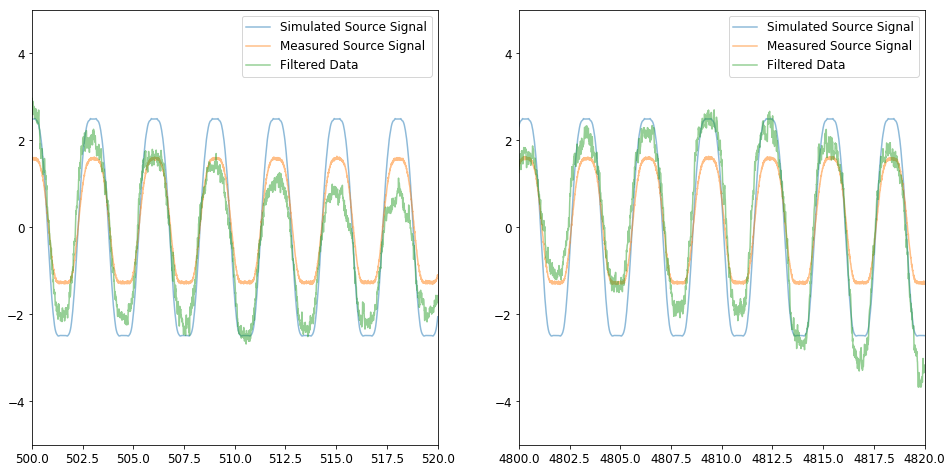

In [143]:
shift = 0.8

subplot(1,2,1)
plot(t_sim_src-t_data[0], data_sim_src,label='Simulated Source Signal', alpha=0.5)
plot(t_src-t_data[0]-shift, (data_src-np.mean(data_src))/np.std(data_src)*3, label='Measured Source Signal', alpha=0.5)
plot(t_data-t_data[0], (data_filtered-np.mean(data_filtered))/np.std(data_filtered), label='Filtered Data', alpha=0.5)
ylim(-5,5)
xlim(500,520)
legend()
subplot(1,2,2)
plot(t_sim_src-t_data[0], data_sim_src,label='Simulated Source Signal', alpha=0.5)
plot(t_src-t_data[0]-shift, (data_src-np.mean(data_src))/np.std(data_src)*3, label='Measured Source Signal', alpha=0.5)
plot(t_data-t_data[0], (data_filtered-np.mean(data_filtered))/np.std(data_filtered), label='Filtered Data', alpha=0.5)
ylim(-5,5)
xlim(4800,4820)
legend()


In [144]:
t_src = t_src -shift

#### As seen above, the source data is not always present for the whole time stream. So we focus on the common region between measured source data and TES data (end simulated source signal by construction) and we take data up to the first stop of the source data (here 2000 seconds after start)

0.875640869140625 1985.3934769630432

0.0 5120.007899045944
0.875640869140625 5120.684731960297
-1614.6075320243835 5016.294790029526

310099
20507
430179


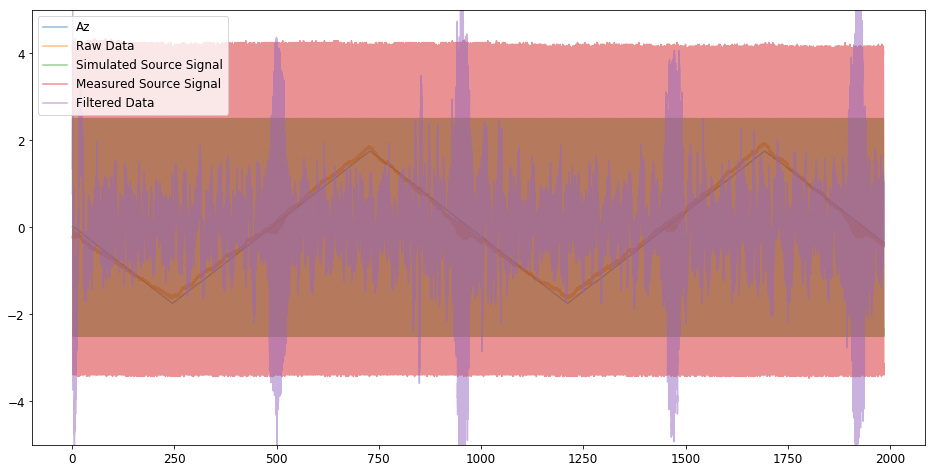

In [147]:
maxtime_src = 2000
oksrc = (t_src-t_data[0]) < maxtime_src
new_t_src = t_src[oksrc]
new_data_src = data_src[oksrc]

tmin = np.max([np.min(t_data-t_data[0]), np.min(new_t_src-t_data[0]), np.min(t_az-t_data[0])])
tmax = np.min([np.max(t_data-t_data[0]), np.max(new_t_src-t_data[0]), np.max(t_az-t_data[0])])

print tmin,tmax
print ''
print np.min(t_data)-t_data[0], np.max(t_data)-t_data[0]
print np.min(t_az)-t_data[0], np.max(t_az)-t_data[0]
print np.min(t_src)-t_data[0], np.max(t_src)-t_data[0]
print ''
okdata = ((t_data-t_data[0]) >= tmin) & ((t_data-t_data[0]) <= tmax)
print okdata.sum()
okaz = ((t_az-t_data[0]) >= tmin) & ((t_az-t_data[0]) <= tmax)
print okaz.sum()
oksrc = ((t_src-t_data[0]) >= tmin) & ((t_src-t_data[0]) <= tmax)
print oksrc.sum()

plot(t_az[okaz]-t_data[0], (az[okaz]-np.mean(az[okaz]))/np.std(az[okaz]), alpha=0.5, label='Az')
plot(t_data[okdata]-t_data[0], (data[okdata]-np.mean(data))/np.std(data[okdata]), label='Raw Data', alpha=0.5)
plot(t_sim_src[okdata]-t_data[0], data_sim_src[okdata],label='Simulated Source Signal', alpha=0.5)
plot(t_src[oksrc]-t_data[0], (data_src[oksrc]-np.mean(data_src[oksrc]))/np.std(data_src[oksrc])*3, label='Measured Source Signal', alpha=0.5)
plot(t_data[okdata]-t_data[0], (data_filtered[okdata]-np.mean(data_filtered[okdata]))/np.std(data_filtered[okdata]), label='Filtered Data', alpha=0.5)
ylim(-5,5)
legend()


We apply the cut

In [148]:
t_data = t_data[okdata]
data = data[okdata]
data_filtered = data_filtered[okdata]
#### Sim Src Signal has the same time axis as the data
t_sim_src = t_sim_src[okdata]
data_sim_src = data_sim_src[okdata]

t_az = t_az[okaz]
az = az[okaz]

t_src = t_src[oksrc]
data_src = data_src[oksrc]

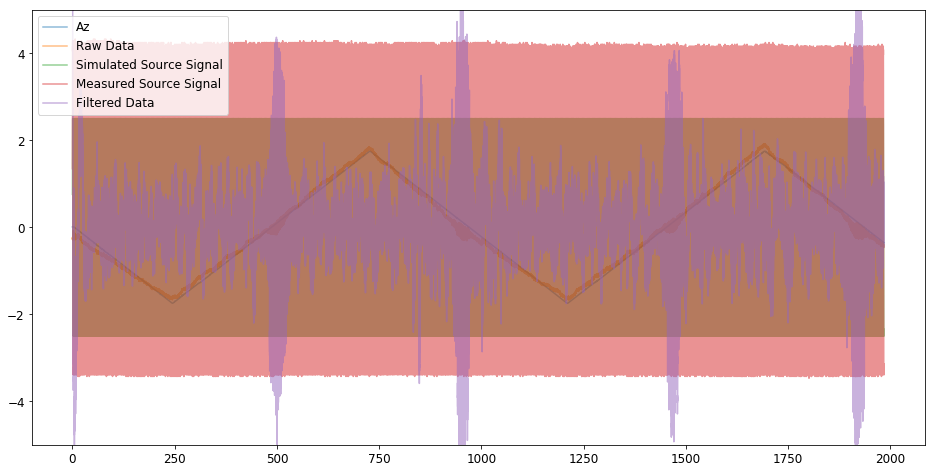

In [149]:
plot(t_az-t_data[0], (az-np.mean(az))/np.std(az), alpha=0.5, label='Az')
plot(t_data-t_data[0], (data-np.mean(data))/np.std(data), label='Raw Data', alpha=0.5)
plot(t_sim_src-t_data[0], data_sim_src,label='Simulated Source Signal', alpha=0.5)
plot(t_src-t_data[0], (data_src-np.mean(data_src))/np.std(data_src)*3, label='Measured Source Signal', alpha=0.5)
plot(t_data-t_data[0], (data_filtered-np.mean(data_filtered))/np.std(data_filtered), label='Filtered Data', alpha=0.5)
ylim(-5,5)
legend()


# Now we can start playing with demodulation

## First Method: RMS per period
we just measure the RMS of the signal in each period of the modulation signal. We then get the signal as a function of time. In the present case, we see the passing of the source with the synthesized beam. Note that this method does not require the knowledge of the signal of the source (be it measured or modelized).

## Second Method: Proper demodulation
This method will require the use of a measure of the modulation source signal. We mutliply the data after filtering  by the modulation signal and get the moving average over a period. Here cone can use the measured source signal or the model.

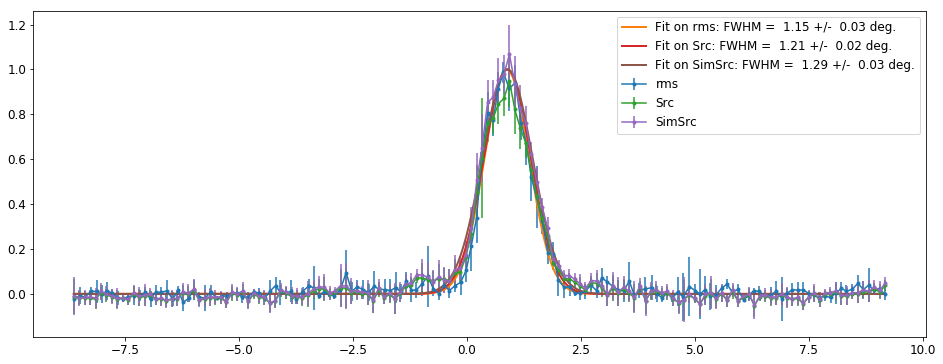

In [325]:
reload(dl)

#### Parameters
ppp = 1./freq_mod
lowcut = 0.1
highcut = 15.
nbins = 150
elevation = 50

angle, sb, dsb, pars, err_pars = dl.general_demodulate(ppp, t_data, data, t_src, data_src, t_az, az, 
                                                    lowcut, highcut, elevation, 
                                                    nbins=nbins, median=True, method='rms', 
                                                    doplot=True, unbinned=False, 
                                                    renormalize_plot=True)

angle, sb, dsb, pars, err_pars = dl.general_demodulate(ppp, t_data, data, t_src, data_src, t_az, az, 
                                                    lowcut, highcut, elevation, 
                                                    nbins=nbins, median=True, method='demod', 
                                                    label='Src',
                                                    doplot=True, unbinned=False, 
                                                    renormalize_plot=True)

angle, sb, dsb, pars, err_pars = dl.general_demodulate(ppp, t_data, data, t_sim_src, data_sim_src, t_az, az, 
                                                    lowcut, highcut, elevation, 
                                                    nbins=nbins, median=True, method='demod', 
                                                    label='SimSrc',
                                                    doplot=True, unbinned=False, 
                                                    renormalize_plot=True)



## Third Method: spline fitting of the modulation signal
This method is mased on fitting slowly varying splines for the amplitude, offset and phase of the modulating signal. It looks efficient but very slow and should for now only be used for a single scan, with a very short time range as below.

Number of initial bins in data: 93755
Number of new bins in data: 799
Number of Splines for Amplitude: 55
Number of Splines for Offset   : 55
Number of Splines for Phase    : 4


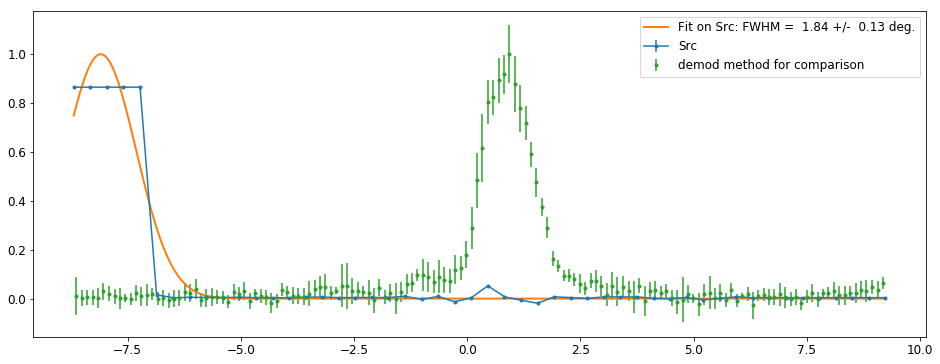

In [327]:
mid = 500
dt = 300
ok_data = np.abs(t_data-t_data[0]-mid) < dt
ok_src = np.abs(t_src-t_data[0]-mid) < dt
ok_az = np.abs(t_az-t_data[0]-mid) < dt

reload(dl)
angle2, sb2, dsb2, pars2, err_pars2 = dl.general_demodulate(ppp, 
                                                            t_data[ok_data], data[ok_data], 
                                                            t_src[ok_src], data_src[ok_src], 
                                                            t_az[ok_az], az[ok_az], 
                                                            lowcut, highcut, elevation, 
                                                            nbins=50, median=True, 
                                                            method='splfit', 
                                                            label='Src',
                                                            doplot=True, unbinned=False, 
                                                            renormalize_plot=True)

errorbar(angle, sb/np.max(sb), yerr=dsb/np.max(sb), fmt='.', label='demod method for comparison')
legend()

## Now loop on all TES with the two first methods

In [305]:
reload(dl)

#### Parameters
ppp = 1./freq_mod
lowcut = 0.1
highcut = 15.
nbins = 150
elevation = 50

methods = ['rms','demod']
scans = np.zeros((len(methods), 128, nbins))
allpars = np.zeros((len(methods), 128, 4))
allpars_err = np.zeros((len(methods), 128, 4))

for TESNum in np.arange(128)+1:
    print(TESNum)
    TESindex = (TESNum-1)
    thedata = a.timeline(TES=TESNum)[okdata]
    for im in xrange(len(methods)):
        angle, sb, dsb, pars, err_pars = dl.general_demodulate(ppp, t_data, thedata, 
                                            t_src, data_src, t_az, az, 
                                            lowcut, highcut, elevation, 
                                            nbins=nbins, median=True, method=methods[im], 
                                            label='Src',
                                            doplot=False, unbinned=False)
        scans[im, TESindex, :] = sb
        allpars[im, TESindex, :] = pars
        allpars_err[im,TESindex,:] = err_pars


    


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128


demodulation_lib.py:61: RuntimeWarning: invalid value encountered in divide
  datar = datar / np.sum(datar)
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +0.000000
    c3 = +0.000000

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = +0.000000
    c3 = +0.000000

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = nan
    c3 = +0.000000

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = +1.000000
    c2 = +0.000000
    c3 = nan

  m.migrad()
fibtools.py:206: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    c0 = nan
    c1 = nan
    c2 = nan
    c3 = nan

  m.migrad()


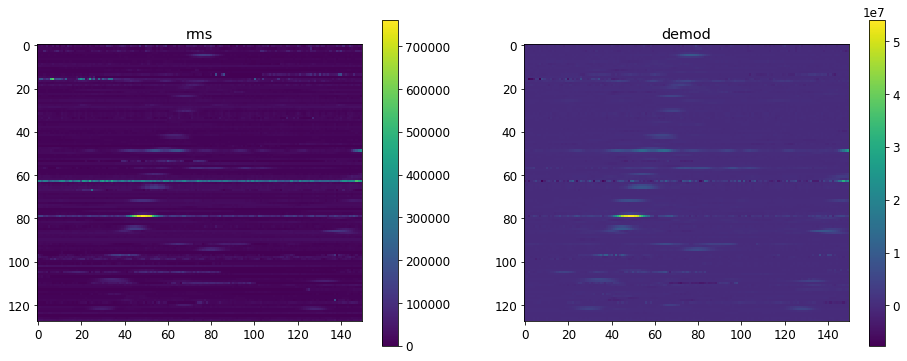

In [312]:
rc('figure',figsize=(16,6))
for im in xrange(len(methods)):
    subplot(1,len(methods),im+1)
    imshow(scans[im,:,:])
    colorbar()
    title(methods[im])

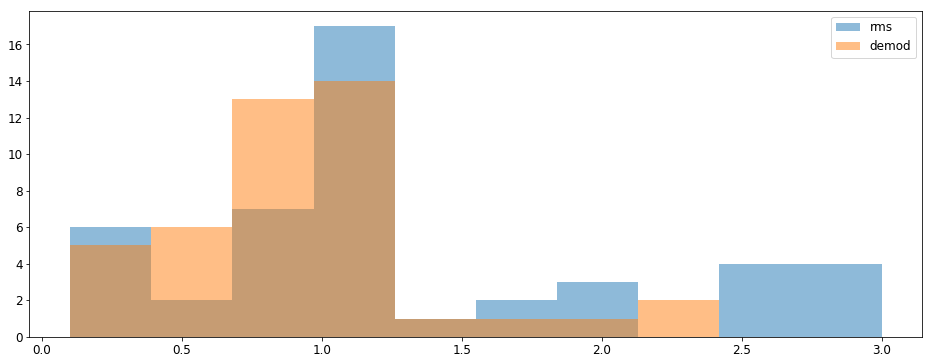

In [322]:
rc('figure',figsize=(16,6))
for im in xrange(len(methods)):
    hist(allpars[im,:,1], bins=10, range=[0.1,3], alpha=0.5, label=methods[im])
legend()

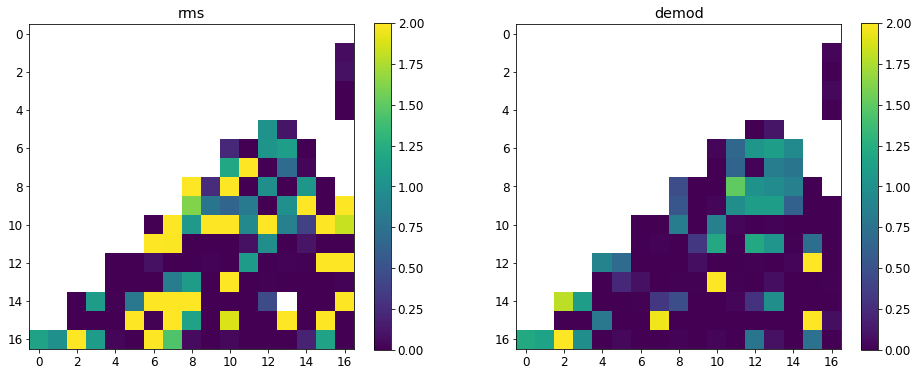

In [317]:
rc('figure',figsize=(16,6))
for im in xrange(len(methods)):
    subplot(1,len(methods),im+1)
    fwhm = allpars[im,:,1]
    img = ft.image_asics(data1=fwhm)
    imshow(img,vmin=0,vmax=2)
    colorbar()
    title(methods[im])